# 01-Data_Exploration

In [2]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [3]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.8 MB/s eta 0:00:0

In [4]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [6]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [7]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:05<00:16,  5.45s/it]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:13<00:13,  6.94s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:19<00:06,  6.60s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:26<00:00,  6.59s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [10]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 4
Test sets: 1
Reading training data...


 25%|██▌       | 1/4 [00:06<00:19,  6.56s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:16<00:16,  8.31s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:22<00:07,  7.26s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2834805, 40)
Splitting the data into 99.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2806456, 40)


In [11]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [12]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [13]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:07<00:00,  7.92s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:07<00:00,  7.93s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing test data to pickle file testing_data.pkl...
Testing data size: (744804, 40)


In [14]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [15]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [18]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


LEAVE_ONE_OUT METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
# Model Poisoning Attack
print("--- Defining Model Poisoning Attack ---")
num_malicious_clients = 3  # about 10% of 33 clients
# Note: client_fn creates clients with string IDs, so we create a list of strings
malicious_client_ids = [str(i) for i in range(num_malicious_clients)]
poison_factor = 3.0 # Amplify weights to overpower other clients. A negative value could be used to flip the weights.

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Scaling weights by a factor of {poison_factor} for malicious clients after local training.")
print("--- Model Poisoning Attack Defined ---")


--- Defining Model Poisoning Attack ---
Poisoning 3 clients: ['0', '1', '2']
Scaling weights by a factor of 3.0 for malicious clients after local training.
--- Model Poisoning Attack Defined ---


In [20]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (77723, 39)
fl_y_train[0].value_counts():
Label
6     12985
4      9788
5      8121
2      7419
3      7368
7      6523
13     5998
15     4825
14     3659
0      1992
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       41
33       25
27       11
31        9
32        9
29        8
20        5
28        5
30        3
Name: count, dtype: int64
fl_y_train[0].unique(): [ 4  6 13 18 25 19 24  2  5  7 14 15  3 17 10 23 11  8  0 33 26 22 12 21
  9 16 27 30 29 28 20 31 32]

--- Client ID: 1 ---
fl_X_train[1].shape: (77624, 39)
fl_y_train[1].value_counts():
Label
6     12985
4      9788
5      8121
3      7368
1      7320
7      6523
13     5998
15     4825
14     3659
0      1992
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16    

Visualize Data Distribution

STRATIFIED Client

In [21]:
#STRATIFIED Client

In [22]:
#LEAVE_ONE_OUT

In [23]:
#Half begign

In [24]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


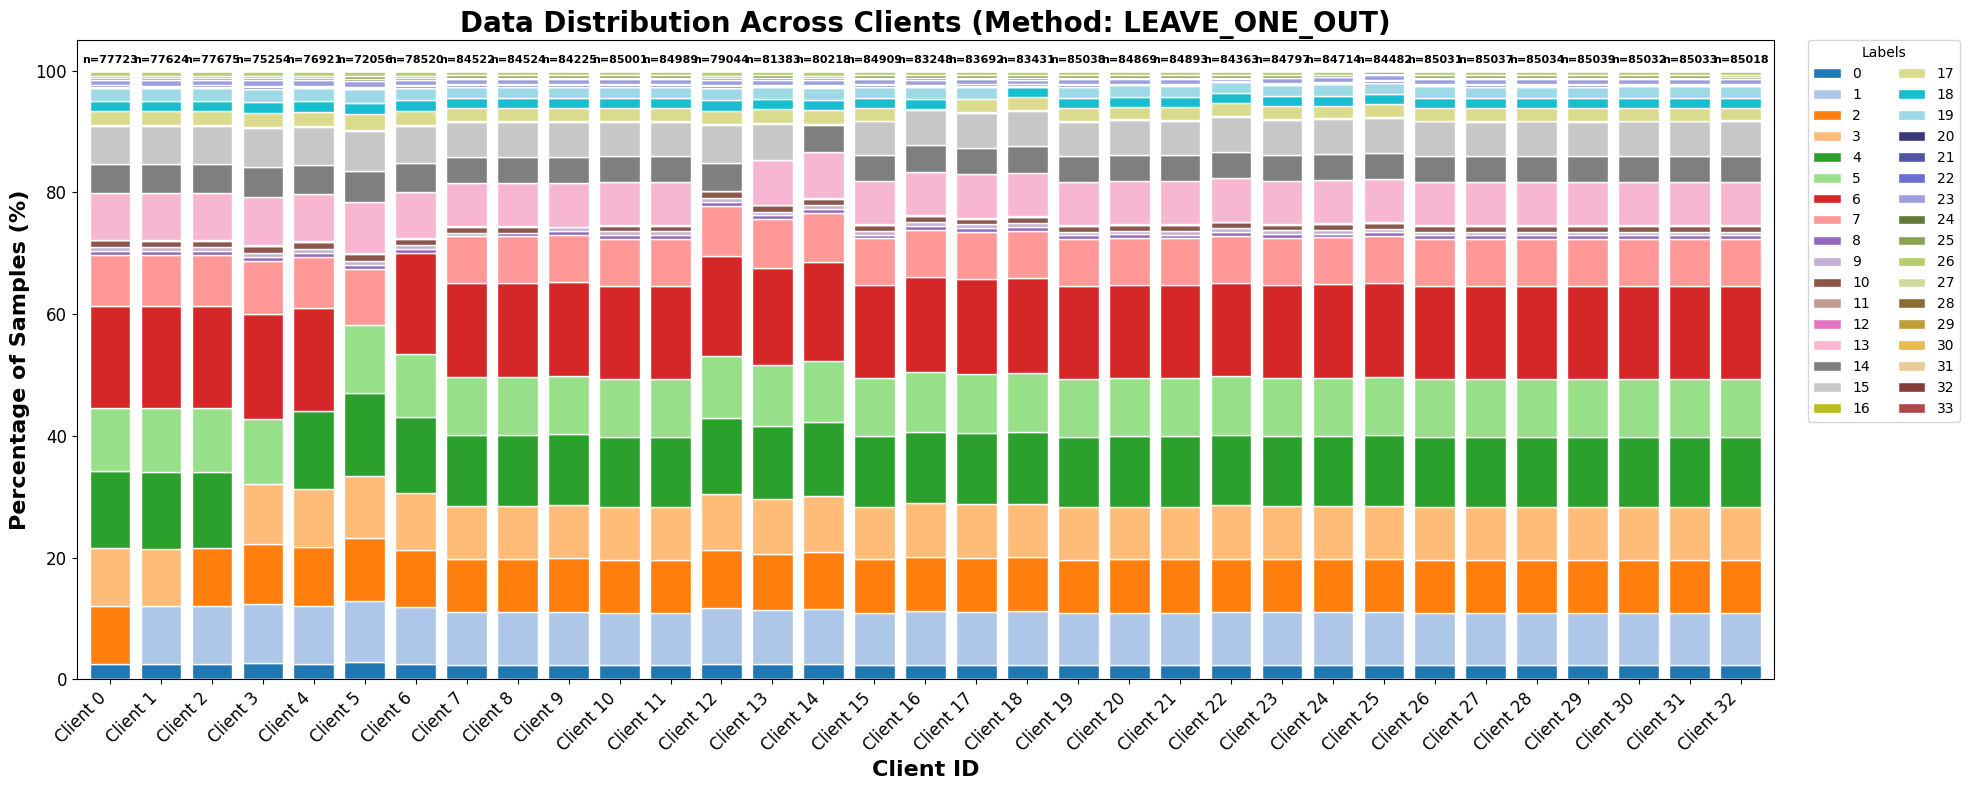

In [25]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [26]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33


Convert the training dataset


In [27]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [28]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [29]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 33
NUM_ROUNDS: 5

Original training size: 2723339
Checking training data split groups
0 : X Shape (77723, 39) Y Shape (77723,)
1 : X Shape (77624, 39) Y Shape (77624,)
2 : X Shape (77675, 39) Y Shape (77675,)
3 : X Shape (75254, 39) Y Shape (75254,)
4 : X Shape (76921, 39) Y Shape (76921,)
5 : X Shape (72056, 39) Y Shape (72056,)
6 : X Shape (78520, 39) Y Shape (78520,)
7 : X Shape (84522, 39) Y Shape (84522,)
8 : X Shape (84524, 39) Y Shape (84524,)
9 : X Shape (84225, 39) Y Shape (84225,)
10 : X Shape (85001, 39) Y Shape (85001,)
11 : X Shape (84989, 39) Y Shape (84989,)
12 : X Shape (79044, 39) Y Shape (79044,)
13 : X Shape (81383, 39) Y Shape (81383,)
14 : X Shape (80218, 39) Y Shape (80218,)
15 : X Shape (84909, 39) Y Shape (84909,)
16 : X Shape (83248, 39) Y Shape (83248,)
17 : X Shape (83692, 39) Y Shape (83692,)
18 : X Shape (83431, 39) Y Shape (83431,)
19 : X Shape (85038, 39) Y Shape (85038,)
20 : X Shape (84869, 39) Y Shape (84869,)
21 : X Shape (84893, 39) Y Sh

In [30]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 136.22155747982657 -0.02330975502083858


#Federated Learning

Import the libraries and print the versions


In [31]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [32]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=1, batch_size=32)
        print ("Client ", self.cid, "Training complete...")

        weights = self.model.get_weights()

        # If the client is in the malicious list, poison the weights
        if self.cid in malicious_client_ids:
            print(f"Client {self.cid} is malicious, applying model poisoning...")
            poisoned_weights = [w * poison_factor for w in weights]
            return poisoned_weights, len(self.train_data), {}

        return weights, len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [34]:
from flwr.server.strategy import FedProx

from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)

# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10, #10,
#         min_evaluate_clients=5, #5,
#         min_available_clients=10, #10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         #evaluate_metrics_aggregation_fn=weighted_average,
# )

# Test FedAdam
# strategy = fl.server.strategy.FedAdam(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         eta=1.0,           # Server-side learning rate
#         beta_1=0.9,
#         beta_2=0.999,
#         tau=1e-9,
#         initial_parameters=initial_parameters
# )

    # strategy = FedAdagrad(
    #     fraction_fit=0.3,
    #     fraction_evaluate=0.3,
    #     min_fit_clients=3,
    #     min_evaluate_clients=3,
    #     min_available_clients=NUM_PARTITIONS,
    #     initial_parameters=ndarrays_to_parameters(params),
    # )

# Define FedProx strategy
strategy = FedProx(
    proximal_mu=1.0,  # Proximal term coefficient (tune as needed)
    fraction_fit=1.0,  # Fraction of clients to sample for training
    fraction_evaluate=1.0,  # Fraction of clients to sample for evaluation
    min_fit_clients=NUM_OF_CLIENTS,  # Minimum number of clients for training
    min_evaluate_clients=NUM_OF_CLIENTS,  # Minimum number of clients for evaluation
    min_available_clients=NUM_OF_CLIENTS,  # Minimum number of available clients
    evaluate_fn=get_evaluate_fn(server_model),
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Deploy simulation... Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33

Writing output to: train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-09-10 09:10:58,441	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7952506062.0, 'object_store_memory': 3976253030.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=2919) WARNING: All log messages before absl::InitializeLog() 

(ClientAppActor pid=2919) Client ID: 5
Server Evaluating... Evaluation Count: 0


(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


23275/23275 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.0084 - loss: 3.6586
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step
Prediction:  [[0.03303871 0.03090987 0.03647137 ... 0.02300343 0.02949581 0.02563336]
 [0.02485404 0.03538184 0.01575146 ... 0.02210929 0.01789092 0.04106185]
 [0.02505639 0.03035164 0.02180757 ... 0.0300109  0.02156751 0.02366602]
 ...
 [0.00861316 0.0371768  0.02259807 ... 0.01290047 0.00993211 0.01885109]
 [0.02607296 0.02877241 0.03327809 ... 0.02603064 0.02451642 0.02877611]
 [0.02599945 0.03008439 0.03374302 ... 0.02487088 0.02535784 0.02831618]] (744790, 34)


INFO :      initial parameters (loss, other metrics): 3.6589646339416504, {'accuracy': 0.008303011767566204}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.0083, Loss: 3.6590
(ClientAppActor pid=2919) Client ID: 6
(ClientAppActor pid=2919) Client  6 Training...


(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919)         
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2919)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2918) Client ID: 3


(ClientAppActor pid=2918) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2918) 
(ClientAppActor pid=2918)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2918)             entirely in future versions of Flower.
(ClientAppActor pid=2918)         
(ClientAppActor pid=2918) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2918)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  17/2454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0653 - loss: 3.4809        
  51/2454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2036 - loss: 3.2729
  83/2454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2707 - loss: 3.0855
 115/2454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3185 - loss: 2.9069
 145/2454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3567 - loss: 2.7480
 177/2454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3909 - loss: 2.5934
 432/2352 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5052 - loss: 1.9086
 483/2352 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5219 - loss: 1.8216
(ClientAppActor pid=2918) Client  3 Training...
  16/2352 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0469 - loss: 3.5915        
1172/2454 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6545 - loss: 1.2180 [repeated 85x across cluster]
1435/2454 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6723 - loss: 1.1193 [repeated 5x across cluster]
2349/2454 ━━━━━━━━━━━━━━━━━━━━

(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)         
(ClientAppActor pid=2918) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

   1/2602 ━━━━━━━━━━━━━━━━━━━━ 2:54:52 4s/step - accuracy: 0.0000e+00 - loss: 3.5475
2222/2352 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6745 - loss: 0.9798 [repeated 7x across cluster]
2352/2352 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.6781 - loss: 0.9598 [repeated 13x across cluster]
  31/2602 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1089 - loss: 3.3973
(ClientAppActor pid=2918) Client  3 Training complete...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 164/2602 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3557 - loss: 2.6677
 174/2602 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3653 - loss: 2.6223


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 186/2602 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3760 - loss: 2.5705
 200/2602 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3876 - loss: 2.5131
 211/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3961 - loss: 2.4704
 218/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4013 - loss: 2.4442
 227/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4077 - loss: 2.4117
 231/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4105 - loss: 2.3976
 243/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4184 - loss: 2.3568


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 254/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4252 - loss: 2.3213
 269/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.4340 - loss: 2.2754
 278/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.4389 - loss: 2.2491
 286/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.4432 - loss: 2.2264


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 298/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4492 - loss: 2.1937
 309/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4545 - loss: 2.1649


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 322/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4605 - loss: 2.1322
 330/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4640 - loss: 2.1128
 342/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4691 - loss: 2.0848
 354/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4741 - loss: 2.0579
 359/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4760 - loss: 2.0470
 362/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.4772 - loss: 2.0405
 371/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.4807 - loss: 2.0215
 376/2602 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4825 - loss: 2.0112
 382/2602 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4848 - loss: 1.9990
 396/2602 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4898 - loss: 1.9714
 413/2602 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4956 - loss: 1.9394
 419/2602 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4976 - loss: 1.9285
 426/2602 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4998 -

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 433/2602 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5020 - loss: 1.9038
 441/2602 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5045 - loss: 1.8901
 445/2602 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5057 - loss: 1.8834
 451/2602 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.5075 - loss: 1.8734
 458/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5096 - loss: 1.8621
 464/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5113 - loss: 1.8525
 467/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5122 - loss: 1.8478
 484/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5169 - loss: 1.8218


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 494/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5195 - loss: 1.8071
 495/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5198 - loss: 1.8056


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 497/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5203 - loss: 1.8027
 499/2602 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5209 - loss: 1.7999
 500/2602 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5211 - loss: 1.7984
 505/2602 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5224 - loss: 1.7913


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 509/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5234 - loss: 1.7857
 512/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5242 - loss: 1.7815


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 518/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5257 - loss: 1.7732
 521/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5265 - loss: 1.7691
 147/2602 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3378 - loss: 2.7493 [repeated 3x across cluster]
 154/2602 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3454 - loss: 2.7151 [repeated 4x across cluster]
 526/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5277 - loss: 1.7624
 529/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5284 - loss: 1.7584


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 537/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5304 - loss: 1.7478
 540/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5311 - loss: 1.7439


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 548/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5329 - loss: 1.7337
 555/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5345 - loss: 1.7248
 558/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5352 - loss: 1.7211
 563/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5363 - loss: 1.7149
 569/2602 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.5376 - loss: 1.7076
 572/2602 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.5383 - loss: 1.7040


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 589/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5419 - loss: 1.6840
 596/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5434 - loss: 1.6759
 606/2602 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5454 - loss: 1.6647
 640/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.5519 - loss: 1.6282
 680/2602 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5589 - loss: 1.5887
 707/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.5634 - loss: 1.5638
 741/2602 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5686 - loss: 1.5342
 762/2602 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.5717 - loss: 1.5169
 793/2602 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.5760 - loss: 1.4926 
 823/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.5800 - loss: 1.4703
 856/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5841 - loss: 1.4471
 894/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5885 - loss: 1.4221
 929/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy:

INFO :      aggregate_fit: received 3 results and 30 failures


2591/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6701 - loss: 0.9559
Server Evaluating... Evaluation Count: 1
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6704 - loss: 0.9545
(ClientAppActor pid=2919) Client  16 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.6654 - loss: 1.2626
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step
Prediction:  [[4.1755015e-05 1.4999765e-04 1.0947543e-04 ... 6.7438066e-07
  2.1291076e-05 2.1484786e-05]
 [1.8620941e-06 2.3735056e-06 9.9928570e-01 ... 4.0183352e-08
  8.3191601e-08 6.3073489e-06]
 [1.4291956e-05 1.8144329e-06 3.3598113e-08 ... 6.0813528e-07
  6.9246204e-07 1.2763606e-05]
 ...
 [1.7014516e-05 4.1276962e-06 3.0565643e-05 ... 2.4788424e-06
  5.5273881e-06 1.4102813e-05]
 [2.7468175e-07 3.5696459e-08 5.0057602e-05 ... 1.6778377e-07
  2.6094130e-08 7.8303192e-06]
 [7.8984317e-07 1.2652647e-07 1.1524375e-04 ... 4.9708007e-07
  7.8987135e-08 1.4258829e-05]] (744790, 34)


INFO :      fit progress: (1, 1.2641228437423706, {'accuracy': 0.665268063545227}, 119.22851875899994)
INFO :      configure_evaluate: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.6653, Loss: 1.2641
(ClientAppActor pid=2919) Client ID: 11
2561/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6695 - loss: 0.9597 [repeated 18x across cluster]


(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919)         
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2919)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2919) Client  11 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   7/2656 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.6866 - loss: 1.1569   
  19/2656 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.6773 - loss: 1.2098
  27/2656 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6756 - loss: 1.2294


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  38/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6767 - loss: 1.2372
  46/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.6774 - loss: 1.2368


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  61/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.6785 - loss: 1.2341
  73/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.6788 - loss: 1.2340
  84/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6786 - loss: 1.2367
  93/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6785 - loss: 1.2385
 105/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6784 - loss: 1.2406
 124/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6774 - loss: 1.2448
 133/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6770 - loss: 1.2461
 144/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6764 - loss: 1.2478


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 158/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6756 - loss: 1.2505
 160/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6755 - loss: 1.2508
 174/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6750 - loss: 1.2527
 184/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6747 - loss: 1.2534


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 199/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6743 - loss: 1.2544
 208/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6741 - loss: 1.2549
 227/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6738 - loss: 1.2559
 233/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6737 - loss: 1.2561
 239/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6736 - loss: 1.2562


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 245/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6736 - loss: 1.2564
 249/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6735 - loss: 1.2565
 259/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6734 - loss: 1.2568


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 269/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6732 - loss: 1.2571
 275/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6731 - loss: 1.2572


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 293/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6729 - loss: 1.2576
 308/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6728 - loss: 1.2578


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 316/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6728 - loss: 1.2578
 322/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6727 - loss: 1.2578
 331/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6726 - loss: 1.2579
 349/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6725 - loss: 1.2581
 357/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6724 - loss: 1.2581
 371/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6723 - loss: 1.2582
 388/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6721 - loss: 1.2584


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 394/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6721 - loss: 1.2585
 406/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6720 - loss: 1.2587
 420/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6718 - loss: 1.2590


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 431/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6716 - loss: 1.2594
 443/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6715 - loss: 1.2599
 454/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6714 - loss: 1.2603


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 461/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6713 - loss: 1.2605
 478/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6711 - loss: 1.2611


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 492/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6711 - loss: 1.2615
 503/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6710 - loss: 1.2617


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 515/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6709 - loss: 1.2619
 525/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6709 - loss: 1.2620


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 537/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6708 - loss: 1.2622
 546/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6708 - loss: 1.2623
 559/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6707 - loss: 1.2625
 569/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6706 - loss: 1.2627


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 583/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6706 - loss: 1.2628
 596/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6705 - loss: 1.2630


ERROR :     Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: 7b6c0dbe5124b24d4fd58f27ba65dd7c3bd4447e8b28a0de310567c7) where the task (actor ID: 016f6115f1fce02090c8403401000000, name=ClientAppActor.__init__, pid=2918, memory used=0.39GB) was running was 12.10GB / 12.67GB (0.954862), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: cd358e7812780f8f318d4f0e3d7b5da364bfdd2161635fae2c212c7a) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-cd358e7812780f8f318d4f0e3d7b5da364bfdd2161635fae2c212c7a*out -ip 172.28.0.12. Top 10 memory users:
PID	MEM(GB)	COMMAND
677	9.63	/usr/bin/python3 -m colab_kernel_launcher -f /root/.local/share/jupyter/runtime/kernel-5a8acb68-e294...
2919	0.41	ray::ClientAppActor.run
2918	0.39	ray::ClientAppActor
1552	0.33	node /datalab/web/pyright

 607/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6704 - loss: 1.2631
 622/2656 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6704 - loss: 1.2632
 627/2656 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6704 - loss: 1.2633


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 637/2656 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6703 - loss: 1.2633
 652/2656 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6703 - loss: 1.2634


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 665/2656 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6703 - loss: 1.2635
 673/2656 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6702 - loss: 1.2635
 735/2656 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6700 - loss: 1.2639
 801/2656 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.6697 - loss: 1.2643
 859/2656 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6696 - loss: 1.2644
 919/2656 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6695 - loss: 1.2641
 987/2656 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6695 - loss: 1.2635
1044/2656 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6695 - loss: 1.2630
1114/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6695 - loss: 1.2624
1168/2656 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6695 - loss: 1.2620
1242/2656 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6694 - loss: 1.2617
1311/2656 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6694 - loss: 1.2615
1389/2656 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6693 - loss

INFO :      aggregate_evaluate: received 1 results and 32 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2592/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6675 - loss: 1.2640
2654/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6674 - loss: 1.2640
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6674 - loss: 1.2640
(ClientAppActor pid=2919) Client 11 evaluation complete - Accuracy: 0.665110, Loss: 1.267210
(ClientAppActor pid=2919) Client ID: 25


(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919)         
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2919)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=2919) Client  25 Training...


(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/li

   1/2641 ━━━━━━━━━━━━━━━━━━━━ 5:57:02 8s/step - accuracy: 0.5625 - loss: 1.5419
  59/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6743 - loss: 0.8928
 118/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6960 - loss: 0.7597
 168/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7048 - loss: 0.7069
 222/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7100 - loss: 0.6723
 278/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7134 - loss: 0.6491
 336/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7160 - loss: 0.6320
 383/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7180 - loss: 0.6210
 433/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7198 - loss: 0.6111
 484/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7215 - loss: 0.6026
 541/2641 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7231 - loss: 0.5946
 591/2641 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7243 - loss: 0.5887
 648/2641 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7253 - loss: 0.

INFO :      aggregate_fit: received 1 results and 32 failures


2538/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7364 - loss: 0.5327
2588/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7365 - loss: 0.5322
Server Evaluating... Evaluation Count: 2
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7366 - loss: 0.5318
(ClientAppActor pid=2919) Client  25 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.7447 - loss: 0.5448
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
Prediction:  [[6.93580523e-06 1.47932933e-05 8.87059832e-06 ... 2.67337902e-10
  1.46991979e-07 3.78464193e-07]
 [5.23109733e-08 6.83025803e-07 9.99805689e-01 ... 2.60896753e-14
  8.26580471e-12 2.06732786e-09]
 [1.24661401e-05 3.06742862e-07 1.41305181e-08 ... 1.46710462e-07
  1.43555397e-07 4.17797175e-08]
 ...
 [2.89486394e-07 3.79506071e-09 2.46947343e-06 ... 1.10113396e-09
  6.59806147e-08 8.55100504e-11]
 [3.19595088e-08 1.32722708e-10 1.14511686e-05 ... 1.03628488e-10
  1.11756264e-10 7.72810154e-08]
 [1.53947610e-07 1.09343468e-0

INFO :      fit progress: (2, 0.5455366373062134, {'accuracy': 0.7450677156448364}, 243.447586485)
INFO :      configure_evaluate: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.7451, Loss: 0.5455
(ClientAppActor pid=2919) Client ID: 2


(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919)         
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2919)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2919) Client  2 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2428 ━━━━━━━━━━━━━━━━━━━━ 1:00:07 1s/step - accuracy: 0.6875 - loss: 0.8277
  11/2428 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.7520 - loss: 0.5859


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  27/2428 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7632 - loss: 0.5520
  38/2428 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7674 - loss: 0.5396


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  53/2428 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7701 - loss: 0.5288
  63/2428 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7700 - loss: 0.5248


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  68/2428 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7697 - loss: 0.5241
  78/2428 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7697 - loss: 0.5222
  87/2428 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7696 - loss: 0.5212
  93/2428 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7697 - loss: 0.5207
 104/2428 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7697 - loss: 0.5199
 114/2428 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7694 - loss: 0.5200
 122/2428 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7692 - loss: 0.5200
 138/2428 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.7689 - loss: 0.5199
 174/2428 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7682 - loss: 0.5204
 201/2428 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7682 - loss: 0.5194 
 208/2428 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7682 - loss: 0.5192
 216/2428 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7681 - loss: 0.5190
 233/2428 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy:

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 245/2428 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7679 - loss: 0.5184
 267/2428 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7679 - loss: 0.5179


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 274/2428 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7678 - loss: 0.5178
 284/2428 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7678 - loss: 0.5177


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 302/2428 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7677 - loss: 0.5173
 309/2428 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7676 - loss: 0.5172


ERROR :     Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: 7b6c0dbe5124b24d4fd58f27ba65dd7c3bd4447e8b28a0de310567c7) where the task (actor ID: 016f6115f1fce02090c8403401000000, name=ClientAppActor.__init__, pid=2918, memory used=0.39GB) was running was 12.10GB / 12.67GB (0.954862), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: cd358e7812780f8f318d4f0e3d7b5da364bfdd2161635fae2c212c7a) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-cd358e7812780f8f318d4f0e3d7b5da364bfdd2161635fae2c212c7a*out -ip 172.28.0.12. Top 10 memory users:
PID	MEM(GB)	COMMAND
677	9.63	/usr/bin/python3 -m colab_kernel_launcher -f /root/.local/share/jupyter/runtime/kernel-5a8acb68-e294...
2919	0.41	ray::ClientAppActor.run
2918	0.39	ray::ClientAppActor
1552	0.33	node /datalab/web/pyright

 321/2428 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7676 - loss: 0.5168
 336/2428 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7676 - loss: 0.5163
 352/2428 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7677 - loss: 0.5158
 353/2428 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7677 - loss: 0.5158
 364/2428 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7676 - loss: 0.5155
 377/2428 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7676 - loss: 0.5153
 386/2428 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7676 - loss: 0.5151
 400/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7675 - loss: 0.5149


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 412/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7675 - loss: 0.5148
 416/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7675 - loss: 0.5148


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 432/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7674 - loss: 0.5147
 444/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7674 - loss: 0.5147
 452/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7673 - loss: 0.5146
 462/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7673 - loss: 0.5146


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 472/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7673 - loss: 0.5145
 498/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7671 - loss: 0.5144
 508/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7671 - loss: 0.5144
 524/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7671 - loss: 0.5143
 536/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7670 - loss: 0.5143
 554/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7670 - loss: 0.5142
 574/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7669 - loss: 0.5141
 582/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7669 - loss: 0.5141
 594/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7668 - loss: 0.5140
 605/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7668 - loss: 0.5140
 615/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7667 - loss: 0.5139


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 627/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7667 - loss: 0.5139
 637/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7667 - loss: 0.5139
 651/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7666 - loss: 0.5138
 655/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7666 - loss: 0.5138
 658/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7666 - loss: 0.5138
 673/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7666 - loss: 0.5137
 678/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7666 - loss: 0.5137
 693/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7666 - loss: 0.5136
 696/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7666 - loss: 0.5136


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 699/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7665 - loss: 0.5136
 701/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7665 - loss: 0.5136
 704/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7665 - loss: 0.5136
 705/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7665 - loss: 0.5135
 716/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7665 - loss: 0.5135
 729/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7665 - loss: 0.5134


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 732/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7665 - loss: 0.5134
 733/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7665 - loss: 0.5134


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 738/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7665 - loss: 0.5133
 743/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7665 - loss: 0.5133
 761/2428 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7664 - loss: 0.5132
 792/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7664 - loss: 0.5130
 847/2428 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7663 - loss: 0.5126
 896/2428 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7662 - loss: 0.5125
 947/2428 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7662 - loss: 0.5123
 986/2428 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7661 - loss: 0.5123
1025/2428 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7661 - loss: 0.5122
1067/2428 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7660 - loss: 0.5122
1110/2428 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7660 - loss: 0.5122 
1147/2428 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7660 - loss: 0.5122
1191/2428 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7659

INFO :      aggregate_evaluate: received 1 results and 32 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2428/2428 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7653 - loss: 0.5128
(ClientAppActor pid=2919) Client 2 evaluation complete - Accuracy: 0.764351, Loss: 0.514381
(ClientAppActor pid=2919) Client ID: 29


(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919)         
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2919)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=2919) Client  29 Training...


(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/li

   1/2658 ━━━━━━━━━━━━━━━━━━━━ 4:17:58 6s/step - accuracy: 0.6875 - loss: 0.5015
   4/2658 ━━━━━━━━━━━━━━━━━━━━ 1:20 30ms/step - accuracy: 0.7324 - loss: 0.6379 
  13/2658 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.7472 - loss: 0.5876
  27/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.7392 - loss: 0.5863


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  31/2658 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7383 - loss: 0.5862
  46/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.7378 - loss: 0.5801


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  52/2658 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7373 - loss: 0.5776
  61/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.7370 - loss: 0.5745
  64/2658 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7368 - loss: 0.5738
  76/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7372 - loss: 0.5702
  82/2658 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7375 - loss: 0.5687
  94/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7387 - loss: 0.5649


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  99/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7392 - loss: 0.5635
 110/2658 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7402 - loss: 0.5609


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 116/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7405 - loss: 0.5597
 118/2658 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7406 - loss: 0.5593
 130/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7411 - loss: 0.5574
 195/2658 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7422 - loss: 0.5498 
 253/2658 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7417 - loss: 0.5458
 302/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7415 - loss: 0.5427
 358/2658 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7416 - loss: 0.5399
 410/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7417 - loss: 0.5379
 468/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7418 - loss: 0.5359
 522/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7419 - loss: 0.5343 
 582/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7419 - loss: 0.5324
 626/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7420 - loss: 0.5310
 679/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7421 

INFO :      aggregate_fit: received 1 results and 32 failures


2639/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7419 - loss: 0.5156
Server Evaluating... Evaluation Count: 3
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7419 - loss: 0.5155
(ClientAppActor pid=2919) Client  29 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.7253 - loss: 0.5039
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
Prediction:  [[3.20998947e-06 9.70987094e-06 3.69779104e-06 ... 4.97458533e-11
  2.79895858e-08 5.82322235e-09]
 [6.84100498e-10 3.90829875e-08 9.99985158e-01 ... 1.96798158e-18
  9.29641490e-17 1.06298282e-12]
 [1.98151929e-06 3.00898051e-07 1.16615322e-08 ... 9.14688858e-09
  3.11644238e-10 2.07763939e-09]
 ...
 [3.67062540e-08 4.58302729e-09 8.47739670e-07 ... 1.58137791e-11
  1.12122429e-10 9.04313991e-14]
 [1.85096347e-08 9.40416234e-12 1.67088785e-06 ... 9.34547665e-12
  1.40180077e-12 5.62841196e-09]
 [1.06435024e-07 1.04589365e-10 1.26490486e-05 ... 8.73167094e-11
  2.45958063e-11 3.44738531e-08]] (744790

INFO :      fit progress: (3, 0.5039687156677246, {'accuracy': 0.7254541516304016}, 398.59111205399995)
INFO :      configure_evaluate: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.7255, Loss: 0.5040
(ClientAppActor pid=2919) Client ID: 6


(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919)         
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2919)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=2919) Client  6 Evaluating...


(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/li

   1/2454 ━━━━━━━━━━━━━━━━━━━━ 2:06:36 3s/step - accuracy: 0.5312 - loss: 0.5380
   4/2454 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.6068 - loss: 0.4938  
  14/2454 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.6617 - loss: 0.4761


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  21/2454 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.6756 - loss: 0.4753
  25/2454 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.6810 - loss: 0.4749


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  26/2454 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.6819 - loss: 0.4752
  27/2454 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - accuracy: 0.6829 - loss: 0.4753
  31/2454 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - accuracy: 0.6864 - loss: 0.4769
  32/2454 ━━━━━━━━━━━━━━━━━━━━ 1:01 26ms/step - accuracy: 0.6871 - loss: 0.4775
  36/2454 ━━━━━━━━━━━━━━━━━━━━ 1:04 27ms/step - accuracy: 0.6900 - loss: 0.4791
  40/2454 ━━━━━━━━━━━━━━━━━━━━ 1:11 30ms/step - accuracy: 0.6919 - loss: 0.4804
  51/2454 ━━━━━━━━━━━━━━━━━━━━ 1:00 25ms/step - accuracy: 0.6933 - loss: 0.4844


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  55/2454 ━━━━━━━━━━━━━━━━━━━━ 59s 25ms/step - accuracy: 0.6935 - loss: 0.4857 
  59/2454 ━━━━━━━━━━━━━━━━━━━━ 1:02 26ms/step - accuracy: 0.6935 - loss: 0.4868


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  60/2454 ━━━━━━━━━━━━━━━━━━━━ 1:03 27ms/step - accuracy: 0.6936 - loss: 0.4870
  62/2454 ━━━━━━━━━━━━━━━━━━━━ 1:05 27ms/step - accuracy: 0.6936 - loss: 0.4877
  63/2454 ━━━━━━━━━━━━━━━━━━━━ 1:07 28ms/step - accuracy: 0.6936 - loss: 0.4880
  66/2454 ━━━━━━━━━━━━━━━━━━━━ 1:10 30ms/step - accuracy: 0.6937 - loss: 0.4888


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  68/2454 ━━━━━━━━━━━━━━━━━━━━ 1:11 30ms/step - accuracy: 0.6938 - loss: 0.4893
  73/2454 ━━━━━━━━━━━━━━━━━━━━ 1:10 30ms/step - accuracy: 0.6941 - loss: 0.4902
  78/2454 ━━━━━━━━━━━━━━━━━━━━ 1:09 29ms/step - accuracy: 0.6943 - loss: 0.4912
  83/2454 ━━━━━━━━━━━━━━━━━━━━ 1:08 29ms/step - accuracy: 0.6946 - loss: 0.4919
  85/2454 ━━━━━━━━━━━━━━━━━━━━ 1:12 30ms/step - accuracy: 0.6947 - loss: 0.4920


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  90/2454 ━━━━━━━━━━━━━━━━━━━━ 1:10 30ms/step - accuracy: 0.6950 - loss: 0.4926
  94/2454 ━━━━━━━━━━━━━━━━━━━━ 1:11 30ms/step - accuracy: 0.6951 - loss: 0.4929
 100/2454 ━━━━━━━━━━━━━━━━━━━━ 1:08 29ms/step - accuracy: 0.6955 - loss: 0.4932
 111/2454 ━━━━━━━━━━━━━━━━━━━━ 1:04 28ms/step - accuracy: 0.6960 - loss: 0.4940
 114/2454 ━━━━━━━━━━━━━━━━━━━━ 1:04 28ms/step - accuracy: 0.6960 - loss: 0.4943
 124/2454 ━━━━━━━━━━━━━━━━━━━━ 1:00 26ms/step - accuracy: 0.6963 - loss: 0.4951
 126/2454 ━━━━━━━━━━━━━━━━━━━━ 1:01 26ms/step - accuracy: 0.6964 - loss: 0.4952
 127/2454 ━━━━━━━━━━━━━━━━━━━━ 1:02 27ms/step - accuracy: 0.6964 - loss: 0.4952


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 133/2454 ━━━━━━━━━━━━━━━━━━━━ 1:01 27ms/step - accuracy: 0.6967 - loss: 0.4954
 138/2454 ━━━━━━━━━━━━━━━━━━━━ 1:01 27ms/step - accuracy: 0.6969 - loss: 0.4956


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 143/2454 ━━━━━━━━━━━━━━━━━━━━ 1:01 27ms/step - accuracy: 0.6970 - loss: 0.4957
 147/2454 ━━━━━━━━━━━━━━━━━━━━ 1:00 26ms/step - accuracy: 0.6971 - loss: 0.4958


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 150/2454 ━━━━━━━━━━━━━━━━━━━━ 1:01 27ms/step - accuracy: 0.6972 - loss: 0.4958
 154/2454 ━━━━━━━━━━━━━━━━━━━━ 1:01 27ms/step - accuracy: 0.6972 - loss: 0.4959
 163/2454 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - accuracy: 0.6974 - loss: 0.4959 
 166/2454 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - accuracy: 0.6975 - loss: 0.4959


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 169/2454 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - accuracy: 0.6975 - loss: 0.4959
 174/2454 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - accuracy: 0.6976 - loss: 0.4960 
 176/2454 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - accuracy: 0.6976 - loss: 0.4959
 182/2454 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - accuracy: 0.6977 - loss: 0.4959
 186/2454 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - accuracy: 0.6978 - loss: 0.4958
 193/2454 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - accuracy: 0.6979 - loss: 0.4957
 199/2454 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - accuracy: 0.6980 - loss: 0.4957
 206/2454 ━━━━━━━━━━━━━━━━━━━━ 55s 25ms/step - accuracy: 0.6982 - loss: 0.4955
 211/2454 ━━━━━━━━━━━━━━━━━━━━ 55s 25ms/step - accuracy: 0.6984 - loss: 0.4954
 219/2454 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - accuracy: 0.6986 - loss: 0.4952
 227/2454 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - accuracy: 0.6989 - loss: 0.4950
 233/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.6991 - loss: 0.4948
 235/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accu

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 239/2454 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - accuracy: 0.6992 - loss: 0.4947
 242/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.6993 - loss: 0.4946
 249/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.6995 - loss: 0.4944


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 253/2454 ━━━━━━━━━━━━━━━━━━━━ 51s 24ms/step - accuracy: 0.6996 - loss: 0.4942
 257/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.6997 - loss: 0.4941
 259/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.6997 - loss: 0.4941
 265/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.6998 - loss: 0.4939


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 267/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.6998 - loss: 0.4939
 272/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.6999 - loss: 0.4937
 273/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.7000 - loss: 0.4937


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 281/2454 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.7001 - loss: 0.4935
 287/2454 ━━━━━━━━━━━━━━━━━━━━ 51s 24ms/step - accuracy: 0.7002 - loss: 0.4934


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 298/2454 ━━━━━━━━━━━━━━━━━━━━ 50s 23ms/step - accuracy: 0.7004 - loss: 0.4931
 320/2454 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step - accuracy: 0.7008 - loss: 0.4924
 383/2454 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.7017 - loss: 0.4915
 441/2454 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7025 - loss: 0.4915
 514/2454 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.7034 - loss: 0.4913
 580/2454 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7042 - loss: 0.4911
 618/2454 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.7045 - loss: 0.4910
 639/2454 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.7047 - loss: 0.4909
 678/2454 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7049 - loss: 0.4908
 735/2454 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7052 - loss: 0.4906
 809/2454 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7056 - loss: 0.4903
 874/2454 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7058 - loss: 0.4902
 947/2454 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accura

INFO :      aggregate_evaluate: received 1 results and 32 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2356/2454 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7076 - loss: 0.4879
2419/2454 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7076 - loss: 0.4878
2454/2454 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7076 - loss: 0.4878
(ClientAppActor pid=2919) Client 6 evaluation complete - Accuracy: 0.707781, Loss: 0.486652
(ClientAppActor pid=2919) Client ID: 30


(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919)         
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2919)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=2919) Client  30 Training...


(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/li

   1/2658 ━━━━━━━━━━━━━━━━━━━━ 5:36:09 8s/step - accuracy: 0.6250 - loss: 0.7117
   3/2658 ━━━━━━━━━━━━━━━━━━━━ 1:16 29ms/step - accuracy: 0.6493 - loss: 0.6486 
   5/2658 ━━━━━━━━━━━━━━━━━━━━ 2:20 53ms/step - accuracy: 0.6730 - loss: 0.6025
   9/2658 ━━━━━━━━━━━━━━━━━━━━ 1:44 39ms/step - accuracy: 0.6980 - loss: 0.5694


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  23/2658 ━━━━━━━━━━━━━━━━━━━━ 1:08 26ms/step - accuracy: 0.7418 - loss: 0.5100
  42/2658 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.7528 - loss: 0.4952
  66/2658 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7553 - loss: 0.4945
  90/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.7563 - loss: 0.4936
 120/2658 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7560 - loss: 0.4933
 150/2658 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7552 - loss: 0.4934
 183/2658 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7536 - loss: 0.4938
 209/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7523 - loss: 0.4944
 244/2658 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7511 - loss: 0.4948
 276/2658 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7504 - loss: 0.4951
 307/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7500 - loss: 0.4953
 339/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7498 - loss: 0.4952
 363/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7

INFO :      aggregate_fit: received 1 results and 32 failures


2570/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7459 - loss: 0.4992
2619/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7459 - loss: 0.4992
Server Evaluating... Evaluation Count: 4
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7459 - loss: 0.4992
(ClientAppActor pid=2919) Client  30 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.7315 - loss: 0.4997
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step


INFO :      fit progress: (4, 0.5000466704368591, {'accuracy': 0.7316182851791382}, 538.831392395)
INFO :      configure_evaluate: strategy sampled 33 clients (out of 33)


Prediction:  [[1.5874926e-06 4.0123464e-06 5.4543557e-06 ... 4.7771453e-12
  2.7151934e-09 2.8508653e-09]
 [1.6965684e-12 1.2966749e-08 9.9998063e-01 ... 4.5103777e-24
  2.6613046e-23 1.5110940e-15]
 [4.4267108e-06 1.1895042e-06 7.7824971e-08 ... 4.3104184e-10
  5.8994858e-12 1.1914801e-09]
 ...
 [1.5841382e-08 4.9300315e-09 2.7719003e-07 ... 1.5382084e-14
  5.7874356e-15 2.4895118e-14]
 [4.4662571e-08 5.8140073e-12 7.3001553e-07 ... 6.2985115e-13
  5.9990607e-14 2.3648408e-09]
 [2.6688937e-07 8.0077688e-11 8.7718508e-06 ... 8.5983555e-12
  2.7229358e-12 1.6432521e-08]] (744790, 34)
Server evaluation complete - Accuracy: 0.7316, Loss: 0.5000
(ClientAppActor pid=2919) Client ID: 14


(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919)         
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2919)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=2919) Client  14 Evaluating...


(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/li

   9/2507 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6896 - loss: 0.5218   
  23/2507 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7287 - loss: 0.4801
  34/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.7359 - loss: 0.4722
  38/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7376 - loss: 0.4702
  46/2507 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.7399 - loss: 0.4680
  60/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.7416 - loss: 0.4675
  71/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.7428 - loss: 0.4679
  88/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.7444 - loss: 0.4678 


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  98/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.7452 - loss: 0.4678
 109/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.7461 - loss: 0.4677


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 115/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7465 - loss: 0.4676
 126/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7471 - loss: 0.4674
 141/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7477 - loss: 0.4676


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 150/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.7479 - loss: 0.4678
 163/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7481 - loss: 0.4680
 165/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7481 - loss: 0.4680
 167/2507 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.7482 - loss: 0.4680
 188/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.7481 - loss: 0.4687
 201/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7482 - loss: 0.4691
 221/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7486 - loss: 0.4695
 236/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7489 - loss: 0.4697


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 244/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7491 - loss: 0.4697
 255/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7493 - loss: 0.4698


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 259/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7494 - loss: 0.4698
 272/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7497 - loss: 0.4698
 281/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7499 - loss: 0.4699
 296/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7503 - loss: 0.4700


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 302/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7504 - loss: 0.4700
 322/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7508 - loss: 0.4701


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 325/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7509 - loss: 0.4701
 326/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7509 - loss: 0.4701
 328/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7510 - loss: 0.4701


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 335/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7511 - loss: 0.4701
 343/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7513 - loss: 0.4702


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 361/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7516 - loss: 0.4703
 367/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7517 - loss: 0.4703
 380/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7520 - loss: 0.4704
 391/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7522 - loss: 0.4705


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 402/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7523 - loss: 0.4706
 408/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7524 - loss: 0.4706


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 416/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7526 - loss: 0.4707
 424/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7527 - loss: 0.4707
 444/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7529 - loss: 0.4708
 448/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7530 - loss: 0.4708
 451/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7530 - loss: 0.4708
 469/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7532 - loss: 0.4709


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 471/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7532 - loss: 0.4709
 474/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7533 - loss: 0.4709
 480/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7533 - loss: 0.4709
 487/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7534 - loss: 0.4710
 492/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7534 - loss: 0.4710
 494/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7534 - loss: 0.4710
 499/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7535 - loss: 0.4710


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 505/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7535 - loss: 0.4710
 511/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.7536 - loss: 0.4710
 515/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.7536 - loss: 0.4711
 518/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.7536 - loss: 0.4711


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 521/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.7537 - loss: 0.4711
 527/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.7537 - loss: 0.4711
 531/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.7537 - loss: 0.4711
 534/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.7537 - loss: 0.4711
 539/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.7538 - loss: 0.4712
 541/2507 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.7538 - loss: 0.4712
 553/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7538 - loss: 0.4712
 564/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7539 - loss: 0.4713


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 569/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7539 - loss: 0.4713
 570/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7539 - loss: 0.4713
 575/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7539 - loss: 0.4713


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 576/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7539 - loss: 0.4713
 580/2507 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.7540 - loss: 0.4714
 586/2507 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.7540 - loss: 0.4714
 605/2507 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7541 - loss: 0.4715
 628/2507 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.7542 - loss: 0.4715
 648/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.7543 - loss: 0.4717
 671/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.7544 - loss: 0.4718
 687/2507 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7545 - loss: 0.4719
 726/2507 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.7546 - loss: 0.4722
 755/2507 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7547 - loss: 0.4723
 805/2507 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7548 - loss: 0.4726
 848/2507 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7550 - loss: 0.4728
 888/2507 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accur

INFO :      aggregate_evaluate: received 1 results and 32 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2402/2507 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7567 - loss: 0.4754
2462/2507 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7567 - loss: 0.4754
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7568 - loss: 0.4754
(ClientAppActor pid=2919) Client 14 evaluation complete - Accuracy: 0.759044, Loss: 0.476728


(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919)         
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2919)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_t

(ClientAppActor pid=2919) Client ID: 25


(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2919) Client  25 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   6/2641 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.7060 - loss: 0.5481  
   8/2641 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - accuracy: 0.7096 - loss: 0.5362
  10/2641 ━━━━━━━━━━━━━━━━━━━━ 1:43 39ms/step - accuracy: 0.7140 - loss: 0.5266
  18/2641 ━━━━━━━━━━━━━━━━━━━━ 1:11 27ms/step - accuracy: 0.7314 - loss: 0.4998
  28/2641 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.7405 - loss: 0.4860
  39/2641 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - accuracy: 0.7396 - loss: 0.4863


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  52/2641 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.7393 - loss: 0.4870
  61/2641 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.7397 - loss: 0.4867
  65/2641 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.7402 - loss: 0.4865
  77/2641 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7413 - loss: 0.4867


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  79/2641 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.7414 - loss: 0.4868
  89/2641 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7420 - loss: 0.4870
  95/2641 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7426 - loss: 0.4868
  96/2641 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7427 - loss: 0.4868
  97/2641 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.7428 - loss: 0.4868


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 108/2641 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.7441 - loss: 0.4859
 114/2641 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7447 - loss: 0.4854
 127/2641 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.7460 - loss: 0.4844
 142/2641 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.7472 - loss: 0.4833
 168/2641 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7487 - loss: 0.4820
 185/2641 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.7494 - loss: 0.4814
 204/2641 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7500 - loss: 0.4813
 229/2641 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.7504 - loss: 0.4812
 262/2641 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7506 - loss: 0.4813
 280/2641 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7506 - loss: 0.4813
 321/2641 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7509 - loss: 0.4808
 343/2641 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7508 - loss: 0.4807
 385/2641 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy

INFO :      aggregate_fit: received 1 results and 32 failures


2559/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7489 - loss: 0.4842
2618/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7490 - loss: 0.4842
Server Evaluating... Evaluation Count: 5
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7490 - loss: 0.4842
(ClientAppActor pid=2919) Client  25 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7525 - loss: 0.5129
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step
Prediction:  [[9.21522258e-07 5.87604347e-07 3.59377100e-06 ... 5.36295869e-11
  4.66441885e-10 1.07403397e-09]
 [1.08632352e-12 4.25093127e-10 9.99991953e-01 ... 5.53493777e-26
  2.16028037e-27 8.47409470e-19]
 [2.52068912e-06 6.15626305e-08 4.32998526e-08 ... 5.63053826e-10
  5.60624680e-13 1.06224141e-10]
 ...
 [1.12030465e-08 4.09269528e-11 2.32846684e-08 ... 1.02708581e-14
  8.48529284e-17 9.26896110e-17]
 [9.26885804e-08 1.18244650e-12 6.91705054e-07 ... 4.83724649e-12
  2.48704137e-14 1.20353427e-09]
 [4.89284389e-07 2.07553141e-1

INFO :      fit progress: (5, 0.5135682225227356, {'accuracy': 0.7529182434082031}, 735.0180600399999)
INFO :      configure_evaluate: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.7529, Loss: 0.5136
(ClientAppActor pid=2919) Client ID: 16


(ClientAppActor pid=2919) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2919) 
(ClientAppActor pid=2919)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2919)             entirely in future versions of Flower.
(ClientAppActor pid=2919)         
(ClientAppActor pid=2919) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2919)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=2919) Client  16 Evaluating...


(ClientAppActor pid=2919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/li

   1/2602 ━━━━━━━━━━━━━━━━━━━━ 1:12:19 2s/step - accuracy: 0.7500 - loss: 0.5213
  15/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7546 - loss: 0.5275
  20/2602 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7569 - loss: 0.5235
  30/2602 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.7594 - loss: 0.5166


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  44/2602 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.7605 - loss: 0.5114
  51/2602 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.7606 - loss: 0.5106


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  65/2602 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.7607 - loss: 0.5089
  66/2602 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.7606 - loss: 0.5088
  68/2602 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7607 - loss: 0.5086


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  77/2602 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7607 - loss: 0.5072
  84/2602 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7605 - loss: 0.5063


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  85/2602 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7605 - loss: 0.5062
  87/2602 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.7604 - loss: 0.5060


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  93/2602 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.7600 - loss: 0.5058
 105/2602 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7594 - loss: 0.5053
 112/2602 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7591 - loss: 0.5050
 127/2602 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.7590 - loss: 0.5044
 140/2602 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7592 - loss: 0.5040
 149/2602 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.7593 - loss: 0.5037


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 167/2602 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7595 - loss: 0.5035
 177/2602 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7595 - loss: 0.5037
 191/2602 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7595 - loss: 0.5039
 194/2602 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7594 - loss: 0.5040
 197/2602 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7594 - loss: 0.5040
 201/2602 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.7594 - loss: 0.5040
 207/2602 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7594 - loss: 0.5041
 217/2602 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7593 - loss: 0.5041


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 233/2602 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7592 - loss: 0.5041
 240/2602 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7592 - loss: 0.5041
 249/2602 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7592 - loss: 0.5040
 256/2602 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7593 - loss: 0.5039


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 260/2602 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7593 - loss: 0.5038
 263/2602 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7593 - loss: 0.5037
 268/2602 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7594 - loss: 0.5036
 269/2602 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7594 - loss: 0.5036
 272/2602 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.7594 - loss: 0.5035
 277/2602 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.7594 - loss: 0.5034


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 282/2602 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.7595 - loss: 0.5033
 284/2602 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.7595 - loss: 0.5032
 286/2602 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.7595 - loss: 0.5032
 292/2602 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.7595 - loss: 0.5031
 296/2602 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.7595 - loss: 0.5031
 302/2602 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.7595 - loss: 0.5030
 305/2602 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.7595 - loss: 0.5030
 307/2602 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - accuracy: 0.7595 - loss: 0.5029
 308/2602 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - accuracy: 0.7596 - loss: 0.5029
 315/2602 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - accuracy: 0.7596 - loss: 0.5029


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 317/2602 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.7596 - loss: 0.5028
 319/2602 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.7596 - loss: 0.5028


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 320/2602 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.7596 - loss: 0.5028
 321/2602 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.7596 - loss: 0.5028
 323/2602 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.7596 - loss: 0.5028
 325/2602 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.7596 - loss: 0.5027


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 327/2602 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.7596 - loss: 0.5027
 328/2602 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.7596 - loss: 0.5027
 332/2602 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.7596 - loss: 0.5026
 342/2602 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.7596 - loss: 0.5025
 345/2602 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.7596 - loss: 0.5025


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 348/2602 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.7596 - loss: 0.5024
 349/2602 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.7596 - loss: 0.5024


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 352/2602 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.7596 - loss: 0.5024
 354/2602 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.7596 - loss: 0.5024
 355/2602 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.7596 - loss: 0.5023
 359/2602 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.7596 - loss: 0.5023
 362/2602 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.7596 - loss: 0.5023
 367/2602 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.7596 - loss: 0.5022
 368/2602 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - accuracy: 0.7596 - loss: 0.5022
 371/2602 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - accuracy: 0.7596 - loss: 0.5022


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 373/2602 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - accuracy: 0.7596 - loss: 0.5022
 374/2602 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - accuracy: 0.7596 - loss: 0.5022


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 375/2602 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - accuracy: 0.7596 - loss: 0.5022
 376/2602 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - accuracy: 0.7596 - loss: 0.5022
 380/2602 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - accuracy: 0.7596 - loss: 0.5022
 394/2602 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - accuracy: 0.7595 - loss: 0.5021
 416/2602 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.7595 - loss: 0.5021
 445/2602 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.7594 - loss: 0.5022
 482/2602 ━━━━━━━━━━━━━━━━━━━━ 36s 17ms/step - accuracy: 0.7594 - loss: 0.5022
 521/2602 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7592 - loss: 0.5022
 560/2602 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.7589 - loss: 0.5024
 599/2602 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.7586 - loss: 0.5027
 640/2602 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.7583 - loss: 0.5029
 670/2602 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.7581 - loss: 0.5031
 712/2602 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accur

INFO :      aggregate_evaluate: received 1 results and 32 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 751.24s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.2672103643417358
INFO :      		round 2: 0.514381468296051
INFO :      		round 3: 0.4866519868373871
INFO :      		round 4: 0.4767276644706726
INFO :      		round 5: 0.5133784413337708
INFO :      	History (loss, centralized):
INFO :      		round 0: 3.6589646339416504
INFO :      		round 1: 1.2641228437423706
INFO :      		round 2: 0.5455366373062134
INFO :      		round 3: 0.5039687156677246
INFO :      		round 4: 0.5000466704368591
INFO :      		round 5: 0.5135682225227356
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.008303011767566204),
INFO :      	              (1, 0.665268063545227),
INFO :      	              (2, 0.7450677156448364),
INFO :      	              (3, 0.7254541516304016),
INFO :      	              (4, 0.7316182851791382),


2602/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7539 - loss: 0.5103
(ClientAppActor pid=2919) Client 16 evaluation complete - Accuracy: 0.752655, Loss: 0.513378
Total time taken:  0:15:19.169501
SIMULATION COMPLETE. Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


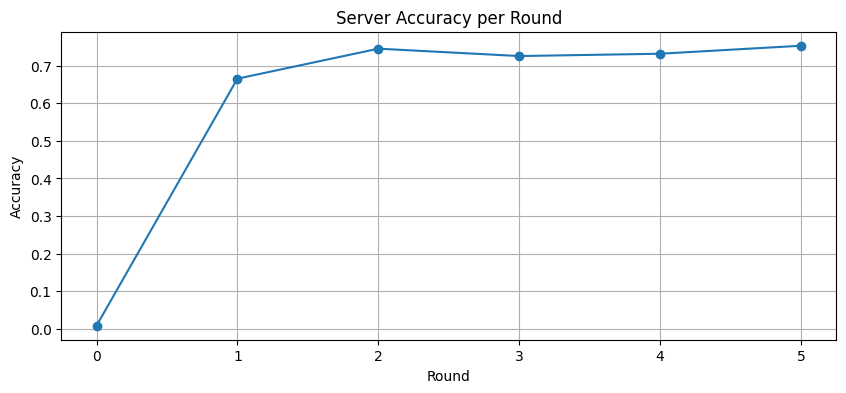

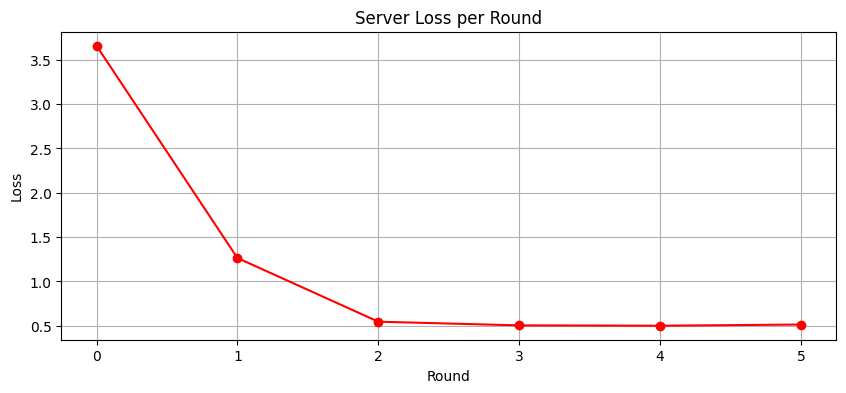

In [35]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()
